# RHESSI (Reuven Ramaty High Energy Solar Spectroscopic Imager)
## Estudio de las llamaradas solares 
### Planteamiento del problema
Los procesos atómicos que tienen lugar en el interior de las estrellas determinan propiedades importantes de procesos estelares y que pueden ser medidas en una escala macroscópica. Un ejemplo familiar son las llamaradas solares producidas por fluctuaciones energéticas en la superficie del Sol. Durante una llamarada, el gas situado en la atmósfera solar alcanza temperaturas de hasta 11 millones de grados Celsius, acelerando particulas a velocidades muy altas en el proceso. Esta aceleración ocasiona emisiones de luz en un rango que va desde el visible hasta rayos gamma, en donde dicha radiación no es apta para penetrar la atmósfera terrestre y por lo tanto no puede ser medida desde la tierra. Para poder registrar estas llamaradas y sus emisiones, se desarrolló la misión RHESSI mediante la creación de un satélite que midiera esta radiación y de esta manera lograr enteder el comportamiento de las llamaradas. El instrumento combina imagenes espectroscópicas del sol para caracterizar las energías presentes en cada llamarada. 

### Sobre los datos
Para iniciar, se tomó la base de datos de la misión RHESSI de la NASA desde la página Kaggle [Solar Flares from RHESSI Mission](https://www.kaggle.com/datasets/khsamaha/solar-flares-rhessi) directamente como un archivo CSV. En esta página se encuentran 2 archivos referentes a los intervalos 2002-2016 y 2002-2018, pero en el estudio se considera el archivo con los datos completos (2002-2018).

En este notebook se plantea un analísis exploratorio de datos con respecto a ciertas caracteristicas de las llamaradas solares, las cuales son duración, posición en x, posición en y las cuales mostrarón tener cierta afinidad con las distribuciónes chi cuadrada en el caso de la duración y la distribucion normal en el caso de las posicion x,y. Sin embargo al realizar los ajustes se tienen densidades de probabilidad con valores muy bajos, ademas de que muchas pruebas de hipotesis realizadas con respecto a la duración no se ajustan a los datos. Esto se debe a que se tienen algunas relaciones que a pesar de no seguir una ley de potencias si tienen relaciones causales (en el caso de los rangos de emisiones de rayos X de bajas y altas energias). Sin embargo con la prueba F de fisher se pueden tener valores interpretables con respecto a la hipotesis nula que las varianzas tienen una proporcion 1 osea $$\frac{\sigma_{1}}{\sigma_{2}}=1$$

### Ingeniería de características

Para limpiar un poco la base de datos, se realiza una unión entre las columnas que contienen información acerca de la fecha y hora de inicio de la erupción, para generar una columna ***DateTime*** que luego se convierte en el index de los datos y descartar entonces algunas columnas como ***flare***, ***star.date***, ***peak***, entre otras. Luego, se crean nuevas columnas que guardan información como la energía máxima a partir de ***energy.kev***, que facilitarán el ordenamiento de los datos cuando este se requiera.

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy as sc
from scipy import stats
import statsmodels.api as sm
plt.style.use("default")
sns.set_palette("dark:violet", n_colors=3, desat=None, color_codes=False)

def Filtro(df,col,cond):
    a=df[col] == cond
    dfa=df[a]
    return dfa  

In [248]:
file_path = r"2002to2018.csv"  #2002to2016.csv
df = pd.read_csv(file_path)
# formatT = '%Y-%m-%d %H:%M:%S'

df['Datetime'] = pd.to_datetime(df['start.date'] +
                                ' ' + 
                                df['start.time'])
df = df.set_index(pd.DatetimeIndex(df['Datetime']))

del df['start.date']
del df['start.time']
del df['Datetime']
del df['flare']
del df['peak']
del df['end']

## Cálculo de energías máximas

Emax = []
for i in df['energy.kev']:
    result = re.findall(r'[\d\.\d]+', i)
    Emax.append(float(result[1]))

#### Tratamiento de outliers

Para ciertos análisis de la base de datos, se observa que hay características que presentan outliers asociados al tipo de llamarada solar observada. Es decir, para eventos no solares (fondo cósmico de microondas) que tienen rangos de energía de 3-6 KeV y para eventos con coordenada radial mayor a 4000 segundos de arco, se presentan outliers exgerados que sabemos no representan el fenómeno solar que se desea estudiar.

In [249]:
df['Emax.kev'] = Emax
df = df[df['radial'] < 4000]
df = df[df['energy.kev'] != '3-6']

df

,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5,Emax.kev
Datetime,,,,,,,,,,,,,,
2002-02-12 21:29:56,712,136,167304.0,12-25,592,-358,692,0,A1,P1,NaN,NaN,NaN,25.0
2002-02-12 21:44:08,288,7,9504.0,6-12,604,-341,694,9811,A1,P1,PE,Q1,NaN,12.0
2002-02-13 00:53:24,216,15,11448.0,6-12,-310,375,487,9825,A1,P1,NaN,NaN,NaN,12.0
2002-02-13 04:22:52,244,20,17400.0,12-25,-277,378,469,9822,A1,P1,NaN,NaN,NaN,25.0
2002-02-13 07:03:52,236,336,313392.0,25-50,-272,390,476,9825,A1,GS,P1,PE,Q2,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-09 16:41:28,124,18,2888.0,6-12,-345,-38,347,2699,A0,DF,P1,PE,Q2,12.0
2018-02-09 18:15:56,104,16,1656.0,6-12,-268,-38,271,2699,A0,DF,P1,PE,Q2,12.0
2018-02-10 13:04:36,148,15,2224.0,6-12,-115,-38,121,2699,A0,DF,P1,PE,Q2,12.0


#### Datos nulos

Al contar el número de datos nulos en cada una de la columnas de la base de datos, se observa que solo las columnas identificadas con flags tienen valores nulos, estos valores nulos no presentarán problemas por el momento ya que no se trabaja con las banderas y solo se usarán para evaluar ciertos resultados como los eventos no solares (rango de energías 3-6 eV). En particular, el hecho de que el evento no sea solar implica omitir dichos datos de la base de datos.

In [250]:
df.isnull().sum()

duration.s              0
peak.c/s                0
total.counts            0
energy.kev              0
x.pos.asec              0
y.pos.asec              0
radial                  0
active.region.ar        0
flag.1                  0
flag.2                  0
flag.3              19278
flag.4              19534
flag.5              58800
Emax.kev                0
dtype: int64

Como se tienen diferentes rangos de energía, es útil hacer una clasificación o filtrado de los datos en función de sus energías. Para este caso se tomarán rangos de energía de 6-12, 12-25 y 25-50 KeV dado que la mayoría de los datos se encuentran en estos rangos. 

In [251]:
energy1 = Filtro(df,'energy.kev','6-12') # Se filtra por rango de energias
energy2 = Filtro(df,'energy.kev','12-25')
energy3 = Filtro(df,'energy.kev','25-50')
dfenergy=pd.concat([energy1,energy2,energy3])

### Análisis primario de datos
#### Histogramas

##### Número de erupciones solares para un rango de energía

<AxesSubplot:xlabel='energy.kev', ylabel='count'>

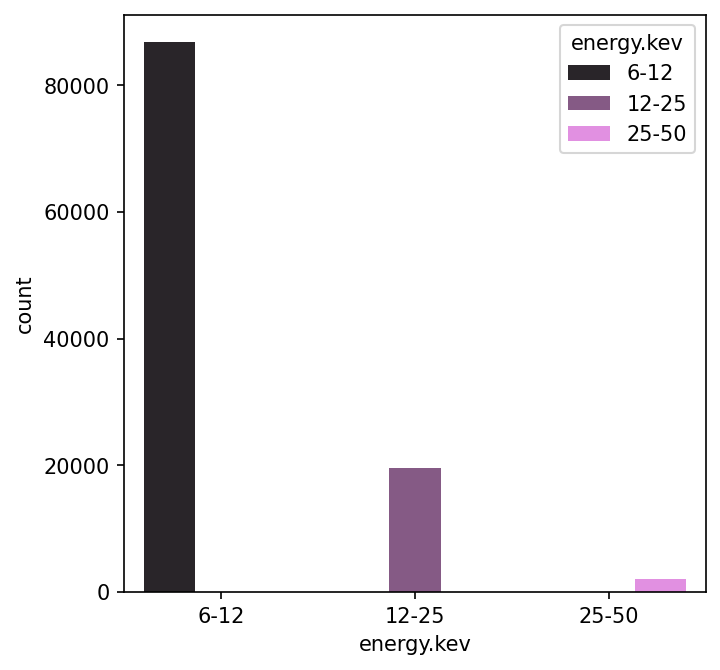

In [252]:
plt.figure(figsize=(5,5), dpi = 150)
sns.countplot(dfenergy.sort_values('Emax.kev'), x="energy.kev", hue='energy.kev')

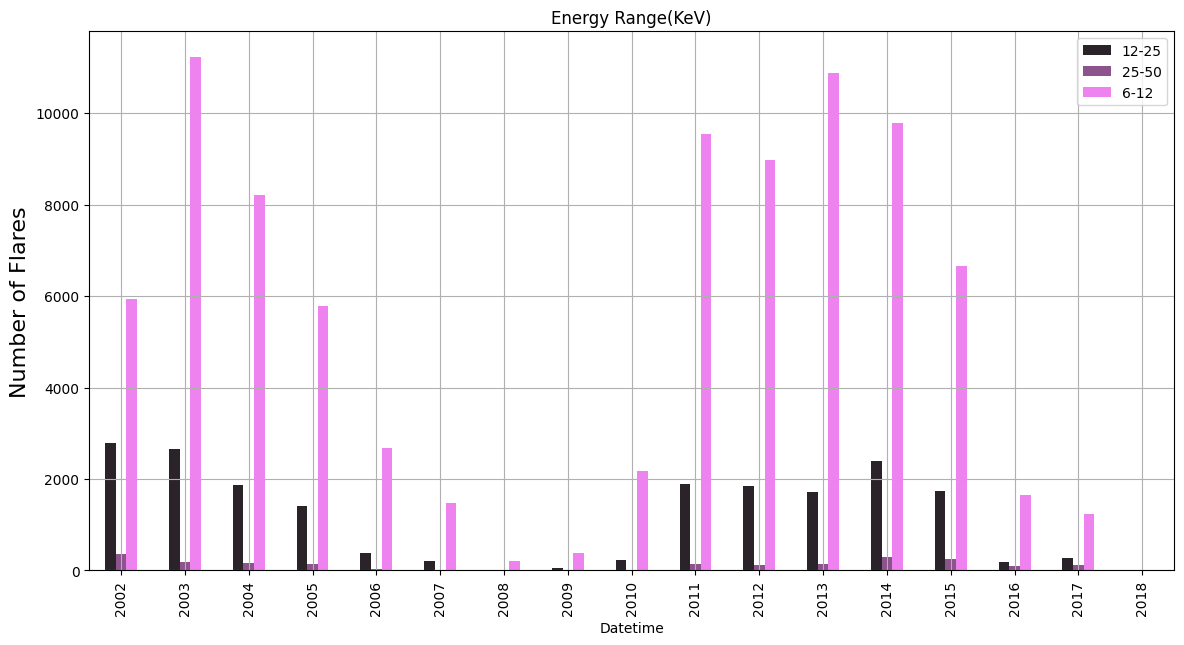

In [253]:
dfenergy.groupby([dfenergy.index.year])['energy.kev'].value_counts().unstack().plot(kind='bar', figsize=(14,7), title='Energy Range(KeV)', grid=True)
plt.ylabel('Number of Flares', fontsize=16)
plt.legend(loc='best', prop={'size': 10})

##### Distribución de las erupciones en la superficie solar junto al histograma de la posición para cada ***(x,y)***
Con esta representación es posible ver como los eventos asociados a diferentes rangos de energía que ocurren en las capas exteriores de la atmósfera solar, son detectados por el satélite y como se distribuyen espacialmente. Se nota que eventos o llamaradas que emiten a una energía en el rango ultra-violeta (6-12 KeV) están distribuidos a través de toda la superficie solar, y que a medida que aumenta la energía emitida por las llamaradas, estas tienden a ubicarse justo en las zonas de mayor velocidad de rotación del sol.

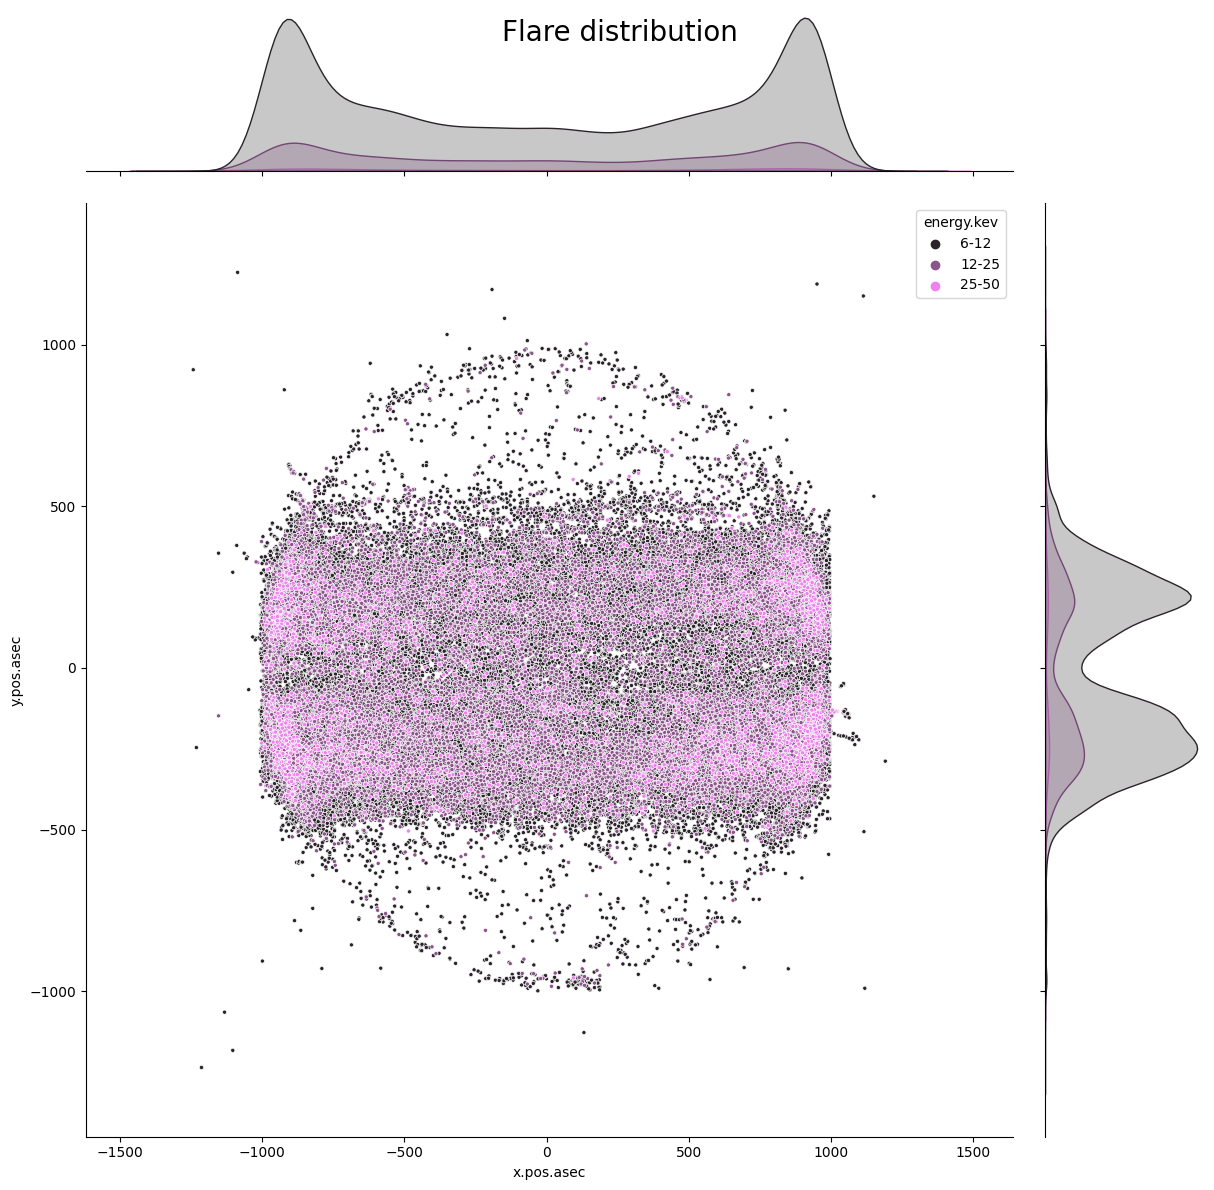

In [254]:
sns.jointplot(data=dfenergy.sort_values('Emax.kev'), x='x.pos.asec', y='y.pos.asec', hue='energy.kev', kind='scatter', height=12, marker=".").fig.suptitle('Flare distribution', fontsize=20),
plt.show()

In [255]:
#separacion por emisferios positivos para x,y
dfx=dfenergy[dfenergy['x.pos.asec'] > 0]
dfx=dfx[dfx['x.pos.asec'] < 1000]
dfy=dfenergy[dfenergy['y.pos.asec']> 0]
dfy=dfy[dfy['y.pos.asec']< 1000]
#dataframes en la posicion positiva en x (a la derecha del 0)
energypox1 = Filtro(dfx,'energy.kev','6-12')
energypox2 = Filtro(dfx,'energy.kev','12-25')
energypox3 = Filtro(dfx,'energy.kev','25-50')
#dataframes en la posicion positiva de y (arriba de 0)
energypoy1 = Filtro(dfy,'energy.kev','6-12')
energypoy2 = Filtro(dfy,'energy.kev','12-25')
energypoy3 = Filtro(dfy,'energy.kev','25-50')

##### Coordenada radial

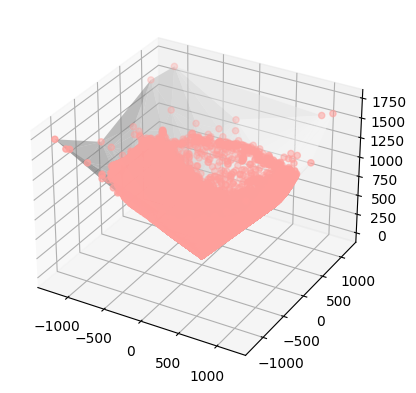

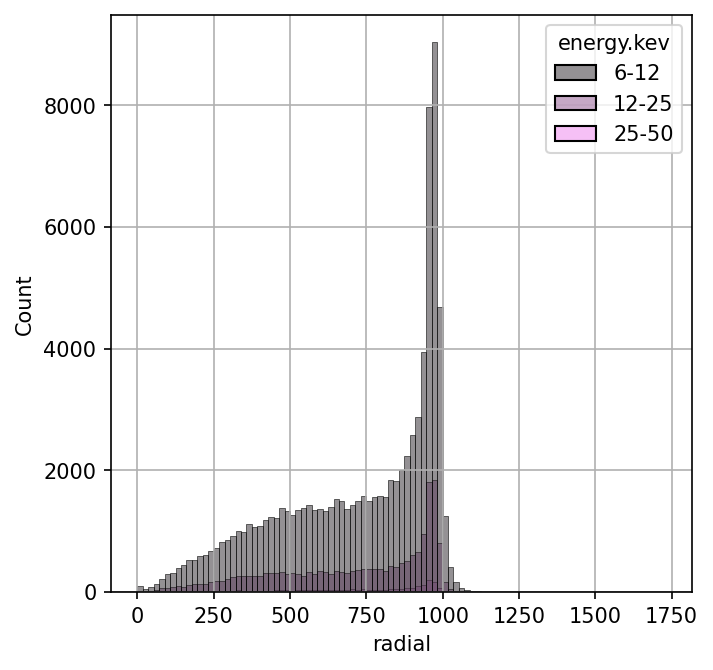

In [256]:
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d') 
ax.plot_trisurf(dfenergy['x.pos.asec'], dfenergy['y.pos.asec'], dfenergy['radial'],color='white', edgecolors=None, alpha=0.5) 
ax.scatter(dfenergy['x.pos.asec'], dfenergy['y.pos.asec'], dfenergy['radial'],c="r") 

plt.figure(figsize=(5,5), dpi = 150)
sns.histplot(dfenergy.sort_values('Emax.kev'), x='radial', hue='energy.kev', fill=True)
plt.grid()
plt.show()

#### Duración

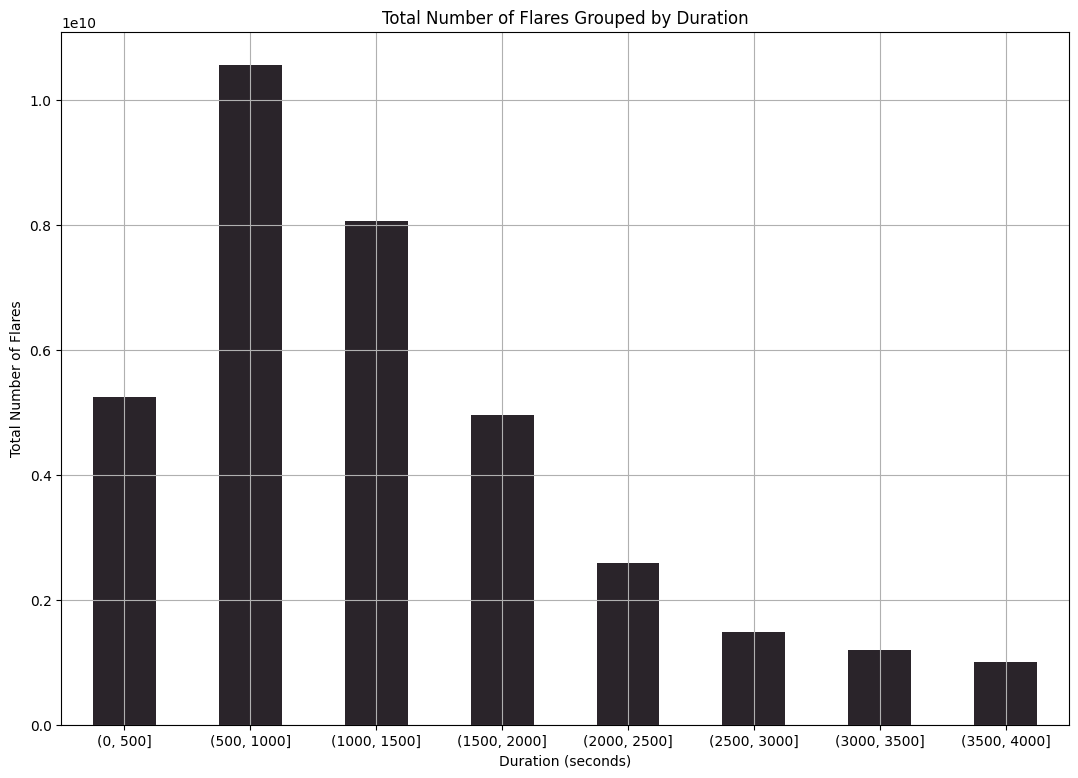

In [257]:
f, ax = plt.subplots(figsize=(13, 9))
dfnew = dfenergy.loc[:, ['duration.s', 'total.counts']]
dfnew2 = dfnew.groupby(pd.cut(dfnew["duration.s"], range(0, max(df['duration.s']), 500))).sum()
ax = dfnew2["total.counts"].plot(kind='bar', title="Total Number of Flares Grouped by Duration")
ax.set_xlabel("Duration (seconds)")
ax.set_ylabel("Total Number of Flares")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

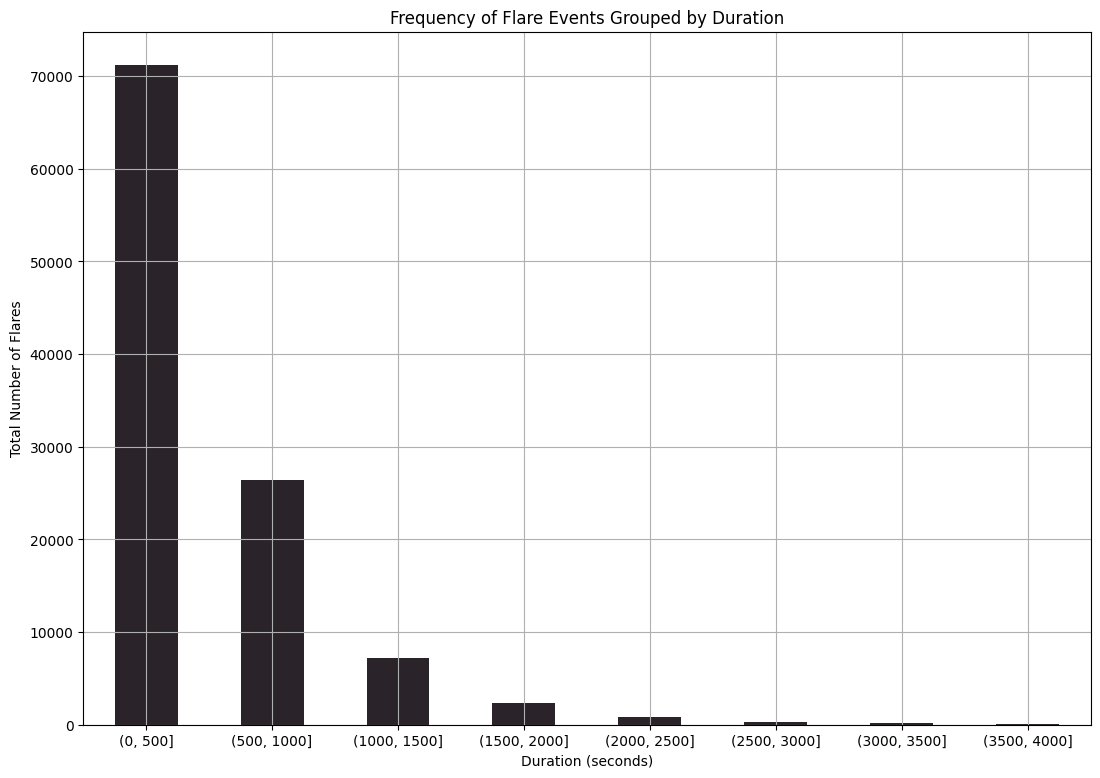

In [240]:
f, ax = plt.subplots(figsize=(13, 9))
dfnew2 = dfenergy.groupby(pd.cut(df["duration.s"], range(0, max(df['duration.s']), 500))).count()
ax = dfnew2["total.counts"].plot(kind='bar', title="Frequency of Flare Events Grouped by Duration")
ax.set_xlabel("Duration (seconds)")
ax.set_ylabel("Total Number of Flares")
plt.xticks(rotation=0)
plt.grid()
plt.show()

#### Matriz de correlación

Con el fin de observar la dependencia de cada una de las variables con respecto a los otras, se construye la matriz de correlación que muestra que las variables no siguen relaciones lineales.

<ipython-input-241-df199c24451e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz=dfenergy.corr(method='pearson')


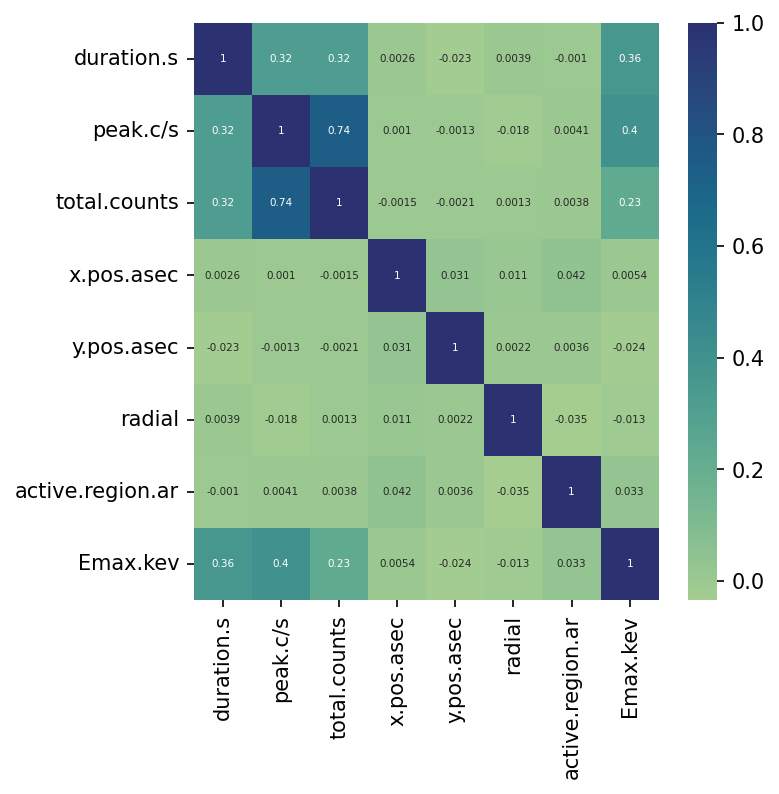

In [241]:
plt.figure(figsize=(5,5), dpi = 150)
matriz=dfenergy.corr(method='pearson')
sns.heatmap(matriz,cmap='crest',annot=True, annot_kws={'fontsize':5})
plt.show()

#### Diagrama de caja y bigotes
##### Se grafica un boxplot para los datos de la posición en **Y**
La utilización de este tipo de gráficos es muy importante ya que dan una pista de como se encuentran distribuidos los datos, y muestra datos outlayers.

Text(0.5, 1.0, 'Boxplot active.region.ar')

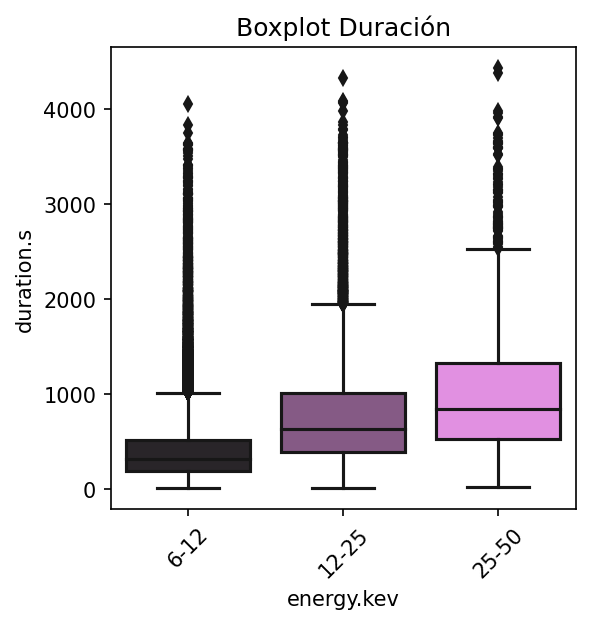

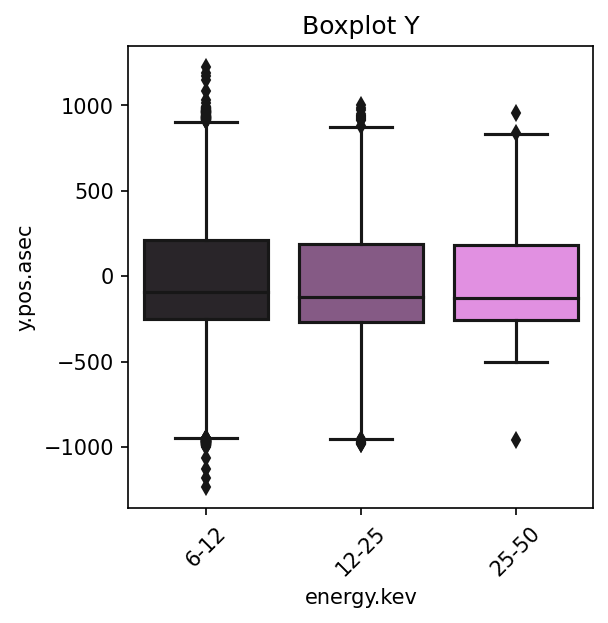

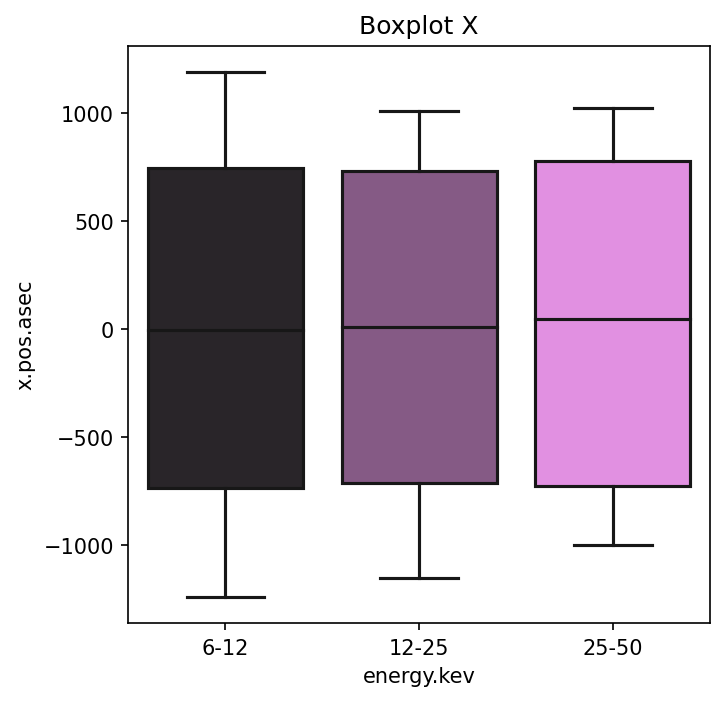

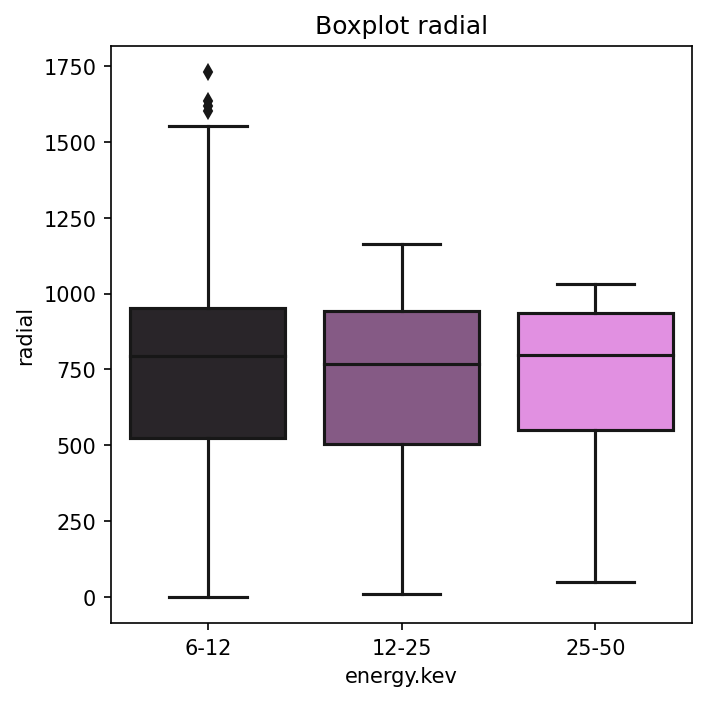

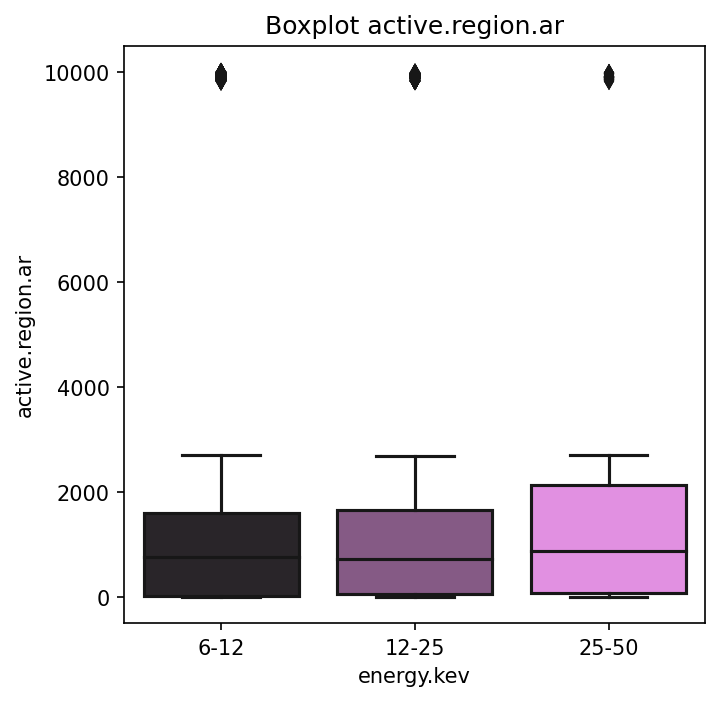

In [242]:
plt.figure(figsize=(4,4), dpi = 150)
sns.boxplot(dfenergy.sort_values('Emax.kev'), x='energy.kev', y="duration.s")
plt.xticks(rotation=45)
plt.title('Boxplot Duración')

plt.figure(figsize=(4,4), dpi = 150)
sns.boxplot(dfenergy.sort_values('Emax.kev'), x='energy.kev', y="y.pos.asec")
plt.xticks(rotation=45)
plt.title('Boxplot Y')

plt.figure(figsize=(5,5), dpi = 150)
sns.boxplot(dfenergy.sort_values('Emax.kev'), x='energy.kev', y="x.pos.asec")
plt.title('Boxplot X')

plt.figure(figsize=(5,5), dpi = 150)
sns.boxplot(dfenergy.sort_values('Emax.kev'), x='energy.kev', y="radial")
plt.title('Boxplot radial')

plt.figure(figsize=(5,5), dpi = 150)
sns.boxplot(dfenergy.sort_values('Emax.kev'), x='energy.kev', y="active.region.ar")
plt.title('Boxplot active.region.ar')


También es posible notar que las distribuciones de las posiciones espaciales de las llamaradas siguen una distribución partiendo del origen hacia alguno de los polos, tal que es simetrica en relación al otro polo, dependiendo del eje espacial.

#### Prueba de hipótesis t de Student y F de Fisher para las duraciones

Con el objetivo de determinar si existe una diferencia significativa entre las medias poblacionales se trabajan pruebas de hipótesis con respecto a dos distribuciones diferentes: t de Student y F de Fisher. Para el primer caso, al evaluar el estadístico se obtienen valores que carecen de sentido (pvalores e intervalos) aunque los datos mostraban una relación entre los valores de duracion promedio y la energía, se observa una independencia del promedio de estos valores entre los rangos energeticos (la duracion media de las llamaradas de cada valor de energia es independiente del resto de valores en los que no se encuentra).

Por otro lado, al plantear la hipotesis nula en la que las medias poblacionales para los valores de energia eran iguales para la F de fisher se observó que el nivel de significancia fue muy bajo ademas que el estadistico de esta hipotesis , queda fuera del intervalo de confianza. Por lo que se tienen suficientes argumentos para rechazar la hipotesis nula, se seleccionó la distribución F de fisher ya que se cumplen que las variables a evaluar (las duraciones de los distintos rangos de energia son variables aleatorias que se aproximan a una distribución chi-cuadrada), a continuacion se muestran las graficas Q-Q para diferentes rangos de energía.

#### Gráficos Q-Q

Con el objetivo de determinar la forma cómo se distribuyen los datos para cierta característica, se realizan gráficos Q-Q. Para el primer caso, se tiene interés es visualizar el comportamiento de la duración de las llamaradas.

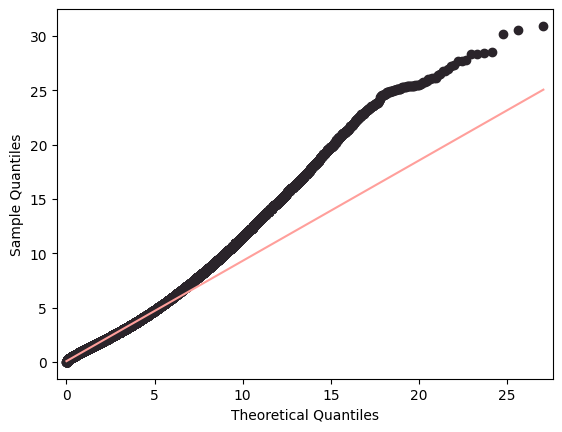

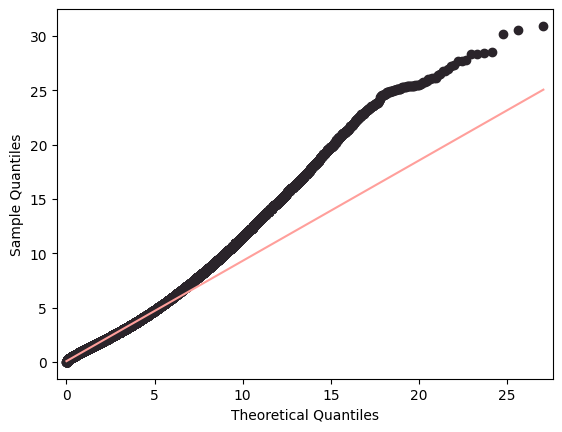

In [243]:
sm.qqplot(dfenergy['duration.s'], line='q', dist=stats.distributions.chi2, fit=True)

Se observa que la duración total de todas las llamaradas registradas no se ajusta exactamente a la distribución $\chi^2$ , sin embargo si se considera una agrupación de datos a partir de los rangos de energía, para las llamaradas en los rangos de 6-12 y 12-25 KeV.

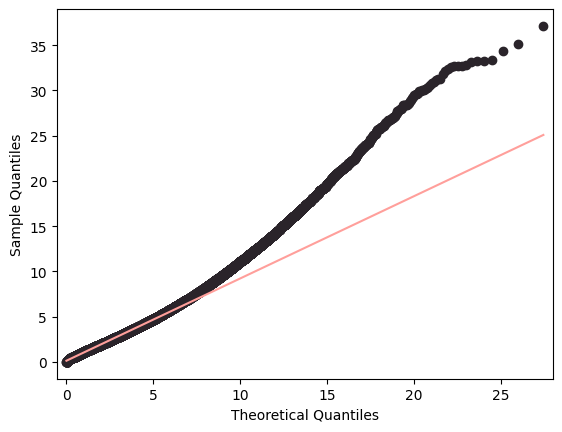

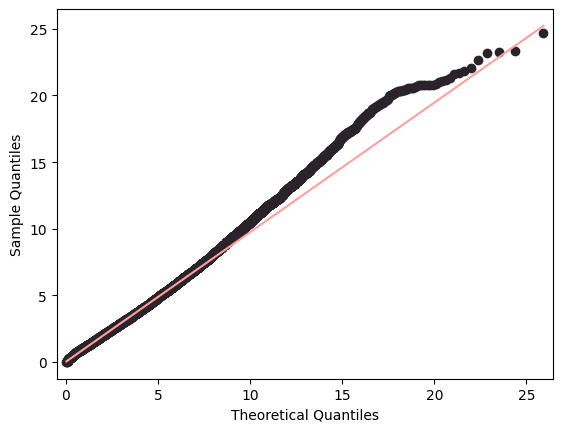

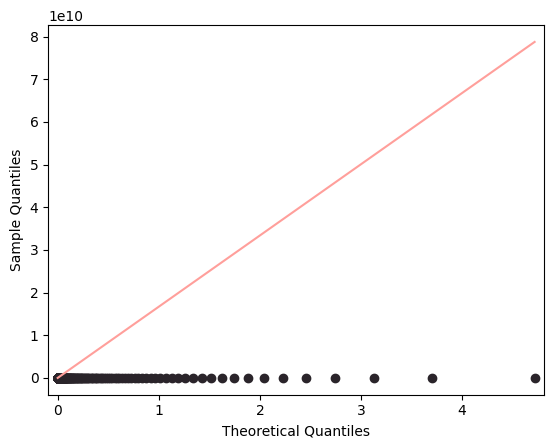

In [244]:
sm.qqplot(energy1['duration.s'] , dist=stats.chi2, fit=True , line='q')
sm.qqplot(energy2['duration.s'], dist=stats.chi2 , fit=True, line='q')
sm.qqplot(energy3['duration.s'], dist=stats.chi2 , fit=True, line='q')

plt.show()

La última gráfica Q-Q corresponde a un rango de energías de 25-50 KeV y no se ajustan a la distribución $\chi^{2}$, esto sugiere que las duraciones tal vez no sigan una distribucion estadistica asociada, abusando del teorema del limite central se hacen Q-Q con respecto a la distribución normal aunque este no es un buen argumento para determinar si se ajustan a alguna distribucion, al ser una muestra tan grande por el mismo teorema tiende a una distribucion normal


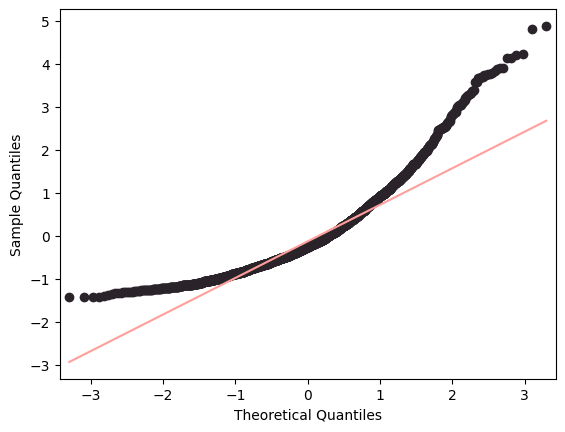

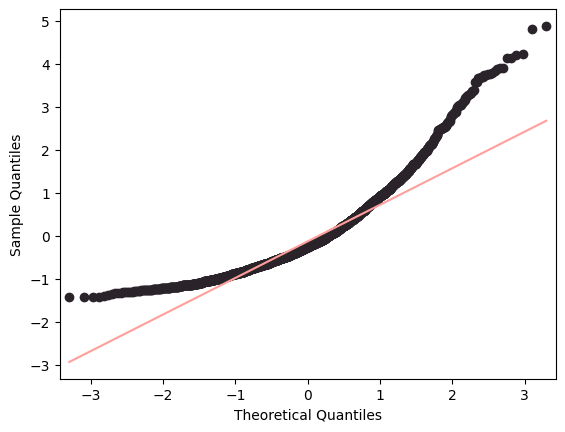

In [245]:
sm.qqplot(energy3['duration.s'] , dist=stats.norm ,fit=True , line= 'q')

Esto sugiere que las propias duraciones dependiendo del rango de energia tienen distribuciones distintas, esto conlleva a la discución de ciertas caracteristicas temporales de las llamaradas tales como el **efecto Nuepert** que relaciona la forma funcional de las energias de rayos X de alta frecuencia y es proporcional a la derivada temporal de la forma funcional de las llamaradas de energias con rayos X de baja frecuencias. Estas dos energias tienen una relación causal de la cual se habla en otras investigaciones.
$$
F(t)_{HXR}=\frac{\delta F(t)_{SHR}}{\delta t}
$$
En la siguiente celda se tienen las funciones para las pruebas estadisticas con respecto a las medias con la distribucion T de student, la prueba de proporcion de varianzas F de fisher y la prueba para un valor medio con la distribucion normal y aunque se tienen valores p 'positivos' realmente por la alta varianza de cada uno de los rangos no se puede confiar en ese ajuste

In [246]:
'''Funcion para prueba estadistica t student'''
def PDMT(dfa,dfb,col,alpha,hip):
# se sacan los promedios, el numero de muestras y las desviaciones estandar con n-1 grados de libertad 'ddof'
    proa=dfa[col].mean()
    prob=dfb[col].mean()
    na=len(dfa[col])
    nb=len(dfb[col])
    sta=dfa[col].std(ddof=(na-1))
    stb=dfb[col].std(ddof=(nb-1))
# se hace la diferencia de las medias muestrales y se calculan los grados de libertad para una t student de 
# dos variables aleatorios con varianzas diferentes y desconocidas esta se lleva al entero menor (aproximación de scatterhwaite)
    Promdif=prob-proa
    v=pow((pow(sta,2)/na)+(pow(stb,2)/nb),2)/((pow(pow(sta,2)/na,2)/na-1)+(pow(pow(stb,2)/nb,2)/nb-1))
    kv=int(v)
# se definen el t estadistico de la prueba Test y el valor critico de una distibucion t de student
# con kv grados de libertad , con un indice de sigfinicancia del 0.05 
    Tdeno=np.sqrt((pow(sta,2)/na)+(pow(stb,2)/nb))
    Tnume=(Promdif-hip)
    Test=Tnume/Tdeno
    conf=(1.0-alpha)
    cv=stats.t.ppf(conf, kv)
#intervalos de confianza a partir del valor v y se determina el valor estadistico p para la hipotesis nula de que mu_a=mu_b
    coin=Tnume-(cv*np.sqrt((pow(sta,2)/na)+(pow(stb,2)/nb)))
    coif=Tnume+(cv*np.sqrt((pow(sta,2)/na)+(pow(stb,2)/nb)))
    ps=1-sc.special.stdtr(kv,np.abs(Test))
    #p=(1.0-stats.t.cdf(np.abs(Test),kv))
    return Test, coin, coif, cv, ps, Promdif

'''Funcion prueba estadistica F de fisher'''
def PDVF(dfa,dfb,col,alpha):
# se definen las medias muestrales, el numero de muestras, los grados de libertad de cada muestra y las desviaciones estandar
# con los respectivos grados de libertad de las muestras
    pro1=dfa[col].mean()
    pro2=dfb[col].mean()
    n1=len(dfa[col])
    n2=len(dfb[col])
    dof1=(n1-1)
    dof2=(n2-1)
    st1=dfa[col].std(ddof=dof1)
    st2=dfb[col].std(ddof=dof2)
# grado de significancia alpha=0.025, intervalo de confianza, F valor critico, , F estadistico, y valor p 
    finf=(1/stats.f.ppf(alpha,dof1,dof2))
    fsup=(1/stats.f.ppf(1-alpha,dof1,dof2))
    Fest=pow(st1,2)/pow(st2,2)
    coin=Fest*finf
    coif=Fest*fsup
    pf=1-stats.f.cdf(abs(Fest),dof1,dof2)
    return coif, coin, Fest , pf ,fsup

'''Funcion prueba estadistica t student para una media de posicion'''
def PDMTU(dfa,col,alpha,hip):
    n=len(dfa[col])
    dof=n-1
    conf=1-alpha
    std=dfa[col].std(ddof=dof)
    prom=dfa[col].mean()
    cv=stats.t.ppf(conf,dof)
    Tden=std/np.sqrt(n)
    T=(prom-hip)/Tden
    p=1-stats.t.cdf(abs(T),dof)
    coin=prom-cv*(std/np.sqrt(n))
    coif=prom+cv*(std/np.sqrt(n))
    return cv, coin, coif, p ,T

'''funcion para calcular el valor critico chi-cuadrado para valores de libertad de la muestra para el analisis del error'''
def PERROR(dfa,y,alpha):
    ip=0
    chil=[]
    for i in range(min(dfa),max(dfa)):
        chil=pow(dfa[i]-y,2)/(dfa[i])
        ip=ip+1
    n=ip
    dof=n-1
    conf=1-alpha
    cv=stats.chi2.ppf(conf,dof)
    chi2=chil.sum()
    return cv, chi2

In [226]:
# pruebas estadisticas para la diferencia del valor medio de la duracion entre dos poblaciones categorizadas por su energia T de student 
# defina su hipotesis
hipt1=0
hipt2=400
hipt3=200
# T test para energias 6-12 y 12-25 , 12-25 y 25-50
Test12, coin12, coif12, cv12, ps12, Promdif12=PDMT(energy1,energy2,'duration.s',0.025,hipt1)
Test23, coin23, coif23, cv23, ps23, Promdif23=PDMT(energy2,energy3,'duration.s',0.025,hipt1)
# pruebas estadisticas para la proporcion de las varianzas de dos poblaciones categorizadas por energia con F de fisher 
# pruebas F de fisher para energias 6-12 y 12-25 para las duraciones
coifdur12, coindur12, Festdur12 , pfdur12, fsupdur12 = PDVF(energy1,energy2,'duration.s',0.05)
coifdur23, coindur23, Festdur23 , pfdur23, fsupdur23 = PDVF(energy2,energy3,'duration.s',0.05)
# pruebas F de fisher para energias 12-25 y 25-50 para las posiciones en x
coifpx12, coinpx12, Festpx12 , pfpx12 ,fsupx12 = PDVF(energypox1,energypox2,'x.pos.asec',0.05)
coifpx23, coinpx23, Festpx23 , pfpx23 ,fsupx23 = PDVF(energypox2,energypox3,'x.pos.asec',0.05)
# pruebas F de fisher para energias 12-25 y 25-50 para las posiciones en y
coifpy12, coinpy12, Festpy12 , pfpy12 ,fsupy12 = PDVF(energypoy1,energypoy2,'y.pos.asec',0.05)
coifpy23, coinpy23, Festpy23 , pfpy23 ,fsupy23 = PDVF(energypoy2,energypoy3,'y.pos.asec',0.05)
# prueba estadistica t student para determinar la media de la posicion x de las energias 6-12 y 12-25
cvnpx1, coinpx1, coifpx1, ppx1 ,Tpx1 = PDMTU(energypox1,'x.pos.asec',0.025,hipt2)
cvnpx2, coinpx2, coifpx2, ppx2 ,Tpx2 = PDMTU(energypox2,'x.pos.asec',0.025,hipt2) 
# prueba estadistica t student para determinar la media de la posicion y de las energias 6-12 y 12-25
cvnpy1, coinpy1, coifpy1, ppy1, Tpy1 = PDMTU(energypoy1,'y.pos.asec',0.025,hipt3)
cvnpy2, coinpy2, coifpy2, ppy2, Tpy2 = PDMTU(energypoy2,'y.pos.asec',0.025,hipt3) 
#RESULTADOS ENERGIAS 6-12 12-25
print('T estadistico para las energias 6-12 y 12-25: ',Test12,' intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:(',coin12,',',coif12,')')
print('T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12 y 12-25:',cv12)
print('valor p estadistica para la hipotesis nula 0 (la hipotesis nula es que las diferencia de las medias es 0)',ps12)

NameError: name 'sc' is not defined

### Algoritmos de Machine Learning

Para comenzar con el uso de algoritmos de machine Learning, se eliminan las columnas que no serán útiles para dicho fin.

In [95]:
dfpred = df.drop(['flag.1', 'flag.2', 'flag.3', 'flag.4', 'flag.5', 'Emax.kev'], axis=1)
dfpred

dfpred['year'] = dfpred.index.year
dfpred['month'] = dfpred.index.month
dfpred['day'] = dfpred.index.day
dfpred = dfpred.drop(['active.region.ar', 'duration.s'], axis=1)

category = {'6-12': 1, '12-25': 2, '25-50': 3, '50-100': 4, 
            '100-300': 5, '300-800': 6, '800-7000': 7, '7000-20000': 8}

dfpred['energy.kev'] = dfpred['energy.kev'].map(category)

dfpred

,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,year,month,day
Datetime,,,,,,,,,
2002-02-12 21:29:56,136,167304.0,2,592,-358,692,2002,2,12
2002-02-12 21:44:08,7,9504.0,1,604,-341,694,2002,2,12
2002-02-13 00:53:24,15,11448.0,1,-310,375,487,2002,2,13
2002-02-13 04:22:52,20,17400.0,2,-277,378,469,2002,2,13
2002-02-13 07:03:52,336,313392.0,3,-272,390,476,2002,2,13
...,...,...,...,...,...,...,...,...,...
2018-02-09 16:41:28,18,2888.0,1,-345,-38,347,2018,2,9
2018-02-09 18:15:56,16,1656.0,1,-268,-38,271,2018,2,9
2018-02-10 13:04:36,15,2224.0,1,-115,-38,121,2018,2,10


In [96]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = dfpred.drop(['energy.kev'], axis = 1)
y = dfpred['energy.kev'] #Target

X_train, X_test, y_train, y_test = train_test_split(X, y)

# scores = cross_val_score(model, dfpred.drop(['energy.kev'], axis=1), dfpred['energy.kev'], cv=10)
# s

#### Decision Tree

In [97]:
from sklearn.tree import DecisionTreeClassifier

modelTree = DecisionTreeClassifier()
modelTree.fit(X_train, y_train)
score = modelTree.score(X_test, y_test)
scoreTr = modelTree.score(X_train, y_train)

scores = cross_val_score(modelTree, dfpred.drop(['energy.kev'], axis=1), dfpred['energy.kev'], cv=10)
scores

score, scoreTr, scores.mean()

/home/equipo/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


(0.7865172653703907, 1.0, 0.36129018689563336)

#### Random Forest

In [98]:
from sklearn.ensemble import RandomForestClassifier

modelBos = RandomForestClassifier()
modelBos.fit(X_train, y_train)
score = modelBos.score(X_test, y_test)
scoreTr = modelBos.score(X_train, y_train)

scores = cross_val_score(modelBos, dfpred.drop(['energy.kev'], axis=1), dfpred['energy.kev'], cv=10)
scores

score, scoreTr, scores.mean()

/home/equipo/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


(0.8594236332344648, 0.9999633815882626, 0.5782091991901099)

#### Matriz de confusión para el Random Forest

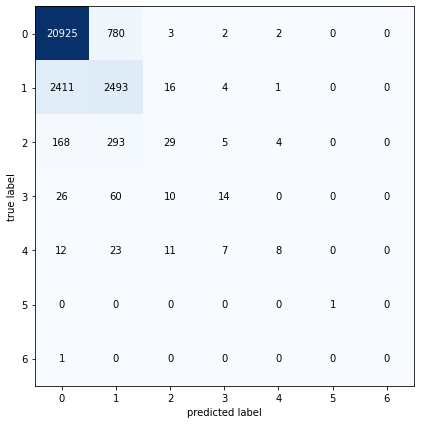

In [100]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = modelBos.predict(X_test)
matriz = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_mat = matriz, figsize=(6,6), show_normed = False)
plt.tight_layout()

In [102]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

model = KNeighborsClassifier()
# model.fit(X_train, y_train)
# kneighbors_predictions = model.predict(X_test)
# kneighbors_score = model.score(X_test, y_test)
# kneighbors_score_train = model.score(X_train, y_train)

# kneighbors_score, kneighbors_score_train


# print ('\nReport on data set:')
# print(metrics.classification_report(y_test, kneighbors_predictions))
# print(metrics.precision_recall_fscore_support(y_test, kneighbors_predictions, average='micro'))
scores = cross_val_score(model, dfpred.drop(['energy.kev'], axis=1), dfpred['energy.kev'], cv=6)
print(scores)

/home/equipo/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


[0.80099967 0.81786224 0.82038888 0.81863122 0.82115786 0.80747048]
